In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sns

from gstatot import driver_genes as dg

sns.set_context("paper", font_scale=1.5)
sns.set_theme(style="ticks")

# The full preprocessed hematopoiesis data required for running this notebook can be downloaded 
# at https://doi.org/10.5281/zenodo.18121450 or generated using the hemo_preprocessing notebook 
# in extra/data_preprocessing/hematopoiesis/ after downloading the raw data from 
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE189161. Prefitted downsampled adatas are 
# located in the archive hemo_downsampled_fitted_adatas.tar.gz at the same link or can be generated 
# using the example-hematopoiesis.ipynb notebook in examples/; see below or the preprint for the parameters 
# used in fitting the models.

data_dir = '../data/hemo_data/prefitted_adatas'

adata_keys  = {'time_key': 'smoothed_age',
               'cell_type_key': 'sink_type',
               'growth_rate_key': 'growth_rate',
               'embed_key': 'X_pca'}

In [2]:
def AP(retrieved_genes, gT_genes):
    P = []
    if len(retrieved_genes) == 0:
        return 0.0
    for k in range(1, len(retrieved_genes) + 1):
        precision_at_k = len(set(retrieved_genes[:k]).intersection(set(gT_genes))) / k
        if retrieved_genes[k-1] in gT_genes:
            P.append(precision_at_k)
    return sum(P) / len(gT_genes)

In [3]:
# add meta cluster annotations for DE baseline computation
postnatal_adata = sc.read_h5ad(f'{data_dir}/postnatal_statOT_fitted.h5ad')
prenatal_adata = sc.read_h5ad(f'{data_dir}/prenatal_statOT_fitted.h5ad')

import re
meta_cluster_anno = pd.read_csv('../data_preprocessing/hematopoiesis/metadata/meta_cluster.csv', index_col=0)
lam = lambda x: re.sub(r'-\d+$', "", x)

de_uniqued_names_post = postnatal_adata.obs_names.map(lam)
postnatal_adata.obs['meta_cluster'] = meta_cluster_anno['meta_cluster'].reindex(de_uniqued_names_post).values

de_uniqued_names_pre = prenatal_adata.obs_names.map(lam)
prenatal_adata.obs['meta_cluster'] = meta_cluster_anno['meta_cluster'].reindex(de_uniqued_names_pre).values


In [4]:
import gc

compute_baseline_DE = True
post_gStatOT_eps = 0.0275 
post_gStatOT_lam = 10

pre_gStatOT_eps = 0.025
pre_gStatOT_lam = 2.5

pre_StatOT_eps = 0.04
post_StatOT_eps = 0.04

for n in [250 ,500]:

    prenatal_down_sampled = sc.read_h5ad(f'{data_dir}/prenatal_gStatOT_fitted_adata_n={n}_lam={pre_gStatOT_lam}_eps2={pre_gStatOT_eps}.h5ad')
    postnatal_down_sampled = sc.read_h5ad(f'{data_dir}/postnatal_gStatOT_fitted_adata_n={n}_lam={post_gStatOT_lam}_eps2={post_gStatOT_eps}.h5ad')
    prenatal_down_sampled_sot = sc.read_h5ad(f'{data_dir}/prenatal_statOT_fitted_adata_n={n}_eps={pre_StatOT_eps}.h5ad')
    postnatal_down_sampled_sot = sc.read_h5ad(f'{data_dir}/postnatal_statOT_fitted_adata_n={n}_eps={post_StatOT_eps}.h5ad')

    prenatal_down_sampled.obs['meta_cluster'] = prenatal_adata.obs['meta_cluster'].reindex(prenatal_down_sampled.obs_names.map(lam)).values
    postnatal_down_sampled.obs['meta_cluster'] = postnatal_adata.obs['meta_cluster'].reindex(postnatal_down_sampled.obs_names.map(lam)).values
    prenatal_down_sampled_sot.obs['meta_cluster'] = prenatal_adata.obs['meta_cluster'].reindex(prenatal_down_sampled_sot.obs_names.map(lam)).values
    postnatal_down_sampled_sot.obs['meta_cluster'] = postnatal_adata.obs['meta_cluster'].reindex(postnatal_down_sampled_sot.obs_names.map(lam)).values

    # contract cell type clusters to those used in the paper by Li et al.

    fate_names_map = {'':'', 'basophil':'Baso/Mast', 'erythroid':'Erythroid', 'lymphocyte':'Lymphoid', 
                      'monocyte_lymphoid':'Mono/DC', 'monocyte_myeloid':'Mono/DC', 'neutrophil':'Granulocyte', 
                      'platelet':'Megakaryocyte'}

    pre_adata_list = [prenatal_down_sampled, prenatal_down_sampled_sot, prenatal_adata] 
    post_adata_list = [postnatal_down_sampled, postnatal_down_sampled_sot, postnatal_adata]

    for adata in pre_adata_list + post_adata_list:
        adata.obs['fate_names'] = adata.obs['sink_type'].map(fate_names_map).astype(str)

    fates = np.unique(postnatal_adata.obs['sink_type'])
    pre_names = ['prenatal gStatOT', 'prenatal StatOT', 'prenatal GT',] 
    post_names = ['postnatal gStatOT', 'postnatal StatOT', 'postnatal GT',] 
    fate_names = np.array(['', 'Baso/Mast', 'Erythroid', 'Lymphoid', 'Mono/DC', 'Granulocyte','Megakaryocyte'])

    def merge_monocyte_fates(adata, t=None):
        if t is None:
            fp_mat = adata.obsm['sink_type_fp'].copy()
        else:
            fp_mat = adata.obsm[f'sink_type_fp_t={t}'].copy()
        fp_mat_new = np.zeros((fp_mat.shape[0], len(fates)-1))
        # preserve missing nan rows
        fp_mat_new[np.isnan(fp_mat).all(axis=1), :] = np.nan

        fate_to_idx = {fate:idx for idx, fate in enumerate(fates[fates != 'monocyte_myeloid'])}
        for i, fate in enumerate(fates):
        
            if fate == 'monocyte_lymphoid' or fate == 'monocyte_myeloid':
                fp_mat_new[:, fate_to_idx['monocyte_lymphoid']] += fp_mat[:, i]
            else:
                fp_mat_new[:, fate_to_idx[fate]] = fp_mat[:, i]

        if not np.all(np.isclose(fp_mat[:, (fates == 'monocyte_lymphoid') | (fates == 'monocyte_myeloid')].sum(axis=1), fp_mat_new[:, 4], equal_nan=True)):
            raise ValueError
        if not np.all(np.isclose(fp_mat[:, ~((fates == 'monocyte_lymphoid') | (fates == 'monocyte_myeloid'))], fp_mat_new[:, [0, 1, 2, 3, 5, 6]], equal_nan=True)):
            raise ValueError

        if t is None:
            adata.obsm['fate_names_fp'] = fp_mat_new
        else:
            adata.obsm[f'fate_names_fp_t={t}'] = fp_mat_new


    for adata, name in zip(pre_adata_list + post_adata_list, pre_names + post_names):
        print(f'Processing {name}...')
        if 'gStatOT' in name:
            for t in np.unique(adata.obs['smoothed_age']):
                merge_monocyte_fates(adata, t=t)

        else:
            merge_monocyte_fates(adata)

    # driver gene identification the correlation b/w fate probability and gene expression
    os.makedirs(f'{data_dir}/../gene_lists/', exist_ok=True)
    adata_keys  = {'time_key': 'smoothed_age',
                   'cell_type_key': 'fate_names'}
    
    pre_gSOT_dg_id = dg.gene_selection(adata=prenatal_down_sampled, adata_keys=adata_keys, full_supp=True)
    pre_gSOT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    post_gSOT_dg_id = dg.gene_selection(adata=postnatal_down_sampled, adata_keys=adata_keys, full_supp=True)
    post_gSOT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    pre_SOT_dg_id = dg.gene_selection(adata=prenatal_down_sampled_sot, adata_keys=adata_keys, full_supp=False)
    pre_SOT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    post_SOT_dg_id = dg.gene_selection(adata=postnatal_down_sampled_sot, adata_keys=adata_keys, full_supp=False)
    post_SOT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    pre_GT_dg_id = dg.gene_selection(adata=prenatal_adata, adata_keys=adata_keys, full_supp=False)
    pre_GT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    post_GT_dg_id = dg.gene_selection(adata=postnatal_adata, adata_keys=adata_keys, full_supp=False)
    post_GT_dg_id.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
    
    
    pre_dg_id_list = [pre_gSOT_dg_id, pre_SOT_dg_id]
    post_dg_id_list = [post_gSOT_dg_id, post_SOT_dg_id]
    
    num_genes = [5, 10, 25, 50]
    n_samples = 1000
    
    res = {'Method':[], 'Age':[], 'Fate':[], 'Top genes':[], 'AP':[]}
    from tqdm import tqdm
    for n_genes in num_genes:
    
        for dg_id in pre_dg_id_list + post_dg_id_list:
            _ = dg_id.rank_genes(n_top_genes=n_samples) 
    
        pre_GT_dg_id.rank_genes(n_top_genes=n_genes) # only take top n_genes from the ground truth as relevant
        post_GT_dg_id.rank_genes(n_top_genes=n_genes)
    
    
        for fate in tqdm(fate_names[1:]):
            for i, age in enumerate(post_GT_dg_id.times):
            
                GT_genes = post_GT_dg_id.cell_type_top_genes[fate]
                gSOT_genes = post_gSOT_dg_id.cell_type_top_genes[fate][age].index.tolist()
                SOT_genes = post_SOT_dg_id.cell_type_top_genes[fate][age].index.tolist()
                GT_genes_a = GT_genes[age].index.tolist()
                GT_genes_am1 = GT_genes[post_GT_dg_id.times[i-1]].index.tolist() if i > 0 else []
                GT_genes_ap1 = GT_genes[post_GT_dg_id.times[i+1]].index.tolist() if i < len(post_GT_dg_id.times)-1 else []
    
                ap_gSOT = AP(gSOT_genes, GT_genes_a)
                ap_SOT = AP(SOT_genes, GT_genes_a)
                if i == 0:
                    ap_GT = AP(GT_genes_ap1, GT_genes_a)
                elif i == len(post_GT_dg_id.times)-1:
                    ap_GT = AP(GT_genes_am1, GT_genes_a)
                else:
                    ap_GT = 0.5 * (AP(GT_genes_am1, GT_genes_a) + AP(GT_genes_ap1, GT_genes_a)) 
    
    
                res['Method'].extend(['gStatOT', 'StatOT', 'GT-TC'])
                res['Age'].extend([str(age) + ' (yrs)']*3)
                res['Fate'].extend([fate]*3)
                res['Top genes'].extend([n_genes]*3)
                res['AP'].extend([ap_gSOT, ap_SOT, ap_GT])
    
            for i, age in enumerate(pre_GT_dg_id.times):
            
                if fate in pre_gSOT_dg_id.cell_type_top_genes.keys():
                    gSOT_genes = pre_gSOT_dg_id.cell_type_top_genes[fate][age].index.tolist()
                    SOT_genes = pre_SOT_dg_id.cell_type_top_genes[fate][age].index.tolist()
                else:
                    gSOT_genes = []
                    SOT_genes = []
    
    
                GT_genes = pre_GT_dg_id.cell_type_top_genes[fate]
                GT_genes_a = GT_genes[age].index.tolist()
                GT_genes_am1 = GT_genes[pre_GT_dg_id.times[i-1]].index.tolist() if i > 0 else []
                GT_genes_ap1 = GT_genes[pre_GT_dg_id.times[i+1]].index.tolist() if i < len(pre_GT_dg_id.times)-1 else []
    
                ap_gSOT = AP(gSOT_genes, GT_genes_a)
                ap_SOT = AP(SOT_genes, GT_genes_a)
                if i == 0:
                    ap_GT = AP(GT_genes_ap1, GT_genes_a)
                elif i == len(pre_GT_dg_id.times)-1:
                    ap_GT = AP(GT_genes_am1, GT_genes_a)
                else:
                    ap_GT = 0.5 * (AP(GT_genes_am1, GT_genes_a) + AP(GT_genes_ap1, GT_genes_a)) 
    
                res['Method'].extend(['gStatOT', 'StatOT', 'GT-TC'])
                res['Age'].extend([str(age) + ' (wks)']*3)
                res['Fate'].extend([fate]*3)
                res['Top genes'].extend([n_genes]*3)
                res['AP'].extend([ap_gSOT, ap_SOT, ap_GT])
    
        fate_cluster_map = {'Baso/Mast':'Basophil', 'Erythroid':'Erythroid', 'Granulocyte':'Granulocyte',
                        'Lymphoid':'Lymphoid', 'Megakaryocyte':'Platelet', 'Mono/DC':'Monocyte'}

    del postnatal_down_sampled.obsp
    gc.collect()
    if compute_baseline_DE:
        for age in post_GT_dg_id.times:
            # DE baseline
            age_adata = postnatal_down_sampled[(postnatal_down_sampled.obs['smoothed_age'] == age)].copy()
            if age_adata[age_adata.obs['meta_cluster']=='Platelet'].shape[0] == 1: # cannot do DE with only one cell in a cluster
                age_adata = age_adata[age_adata.obs['meta_cluster'] != 'Platelet'].copy()
            if age_adata[age_adata.obs['meta_cluster']=='Basophil'].shape[0] == 1:
                age_adata = age_adata[age_adata.obs['meta_cluster'] != 'Basophil'].copy()

            sc.tl.rank_genes_groups(age_adata, groupby='meta_cluster', reference='rest', method='wilcoxon')

            for n_genes in num_genes:
                post_GT_dg_id.rank_genes(n_top_genes=n_genes)
                for fate_ in fate_names[1:]:
                    fate = fate_cluster_map[fate_]
                    if fate in age_adata.uns['rank_genes_groups']['names'].dtype.names:
                        de_genes = age_adata.uns['rank_genes_groups']['names'][fate][:n_samples].tolist()
                        GT_genes = post_GT_dg_id.cell_type_top_genes[fate_][age].index.tolist()
                        res['Method'].append('DE baseline')
                        res['Age'].append(str(age) + ' (yrs)')
                        res['Fate'].append(fate_)
                        res['Top genes'].append(n_genes)
                        res['AP'].append(AP(de_genes, GT_genes))
            del age_adata
            gc.collect()

        for age in pre_GT_dg_id.times:
            # DE baseline
            age_adata = prenatal_down_sampled[(prenatal_down_sampled.obs['smoothed_age'] == age)].copy()
            if age_adata[age_adata.obs['meta_cluster']=='Platelet'].shape[0] == 1: # cannot do DE with only one cell in a cluster
                age_adata = age_adata[age_adata.obs['meta_cluster'] != 'Platelet'].copy()
            if age_adata[age_adata.obs['meta_cluster']=='Basophil'].shape[0] == 1:
                age_adata = age_adata[age_adata.obs['meta_cluster'] != 'Basophil'].copy()

            sc.tl.rank_genes_groups(age_adata, groupby='meta_cluster', reference='rest', method='wilcoxon')

            for n_genes in num_genes:
                pre_GT_dg_id.rank_genes(n_top_genes=n_genes) 
                for fate_ in fate_names[1:]:
                    fate = fate_cluster_map[fate_]
                    if fate in age_adata.uns['rank_genes_groups']['names'].dtype.names:
                        de_genes = age_adata.uns['rank_genes_groups']['names'][fate][:n_samples].tolist()
                        GT_genes = pre_GT_dg_id.cell_type_top_genes[fate_][age].index.tolist()
                        res['Method'].append('DE baseline')
                        res['Age'].append(str(age) + ' (wks)')
                        res['Fate'].append(fate_)
                        res['Top genes'].append(n_genes)
                        res['AP'].append(AP(de_genes, GT_genes))
            del age_adata
            gc.collect()

    
    
    AP_df = pd.DataFrame(res)
    AP_df.to_csv(f'{data_dir}/../gene_lists/driver_gene_AP_results_n={n}.csv', index=False)


Processing prenatal gStatOT...
Processing prenatal StatOT...
Processing prenatal GT...
Processing postnatal gStatOT...
Processing postnatal StatOT...
Processing postnatal GT...


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


Processing prenatal gStatOT...
Processing prenatal StatOT...
Processing prenatal GT...
Processing postnatal gStatOT...
Processing postnatal StatOT...
Processing postnatal GT...


100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


## Figure 5 

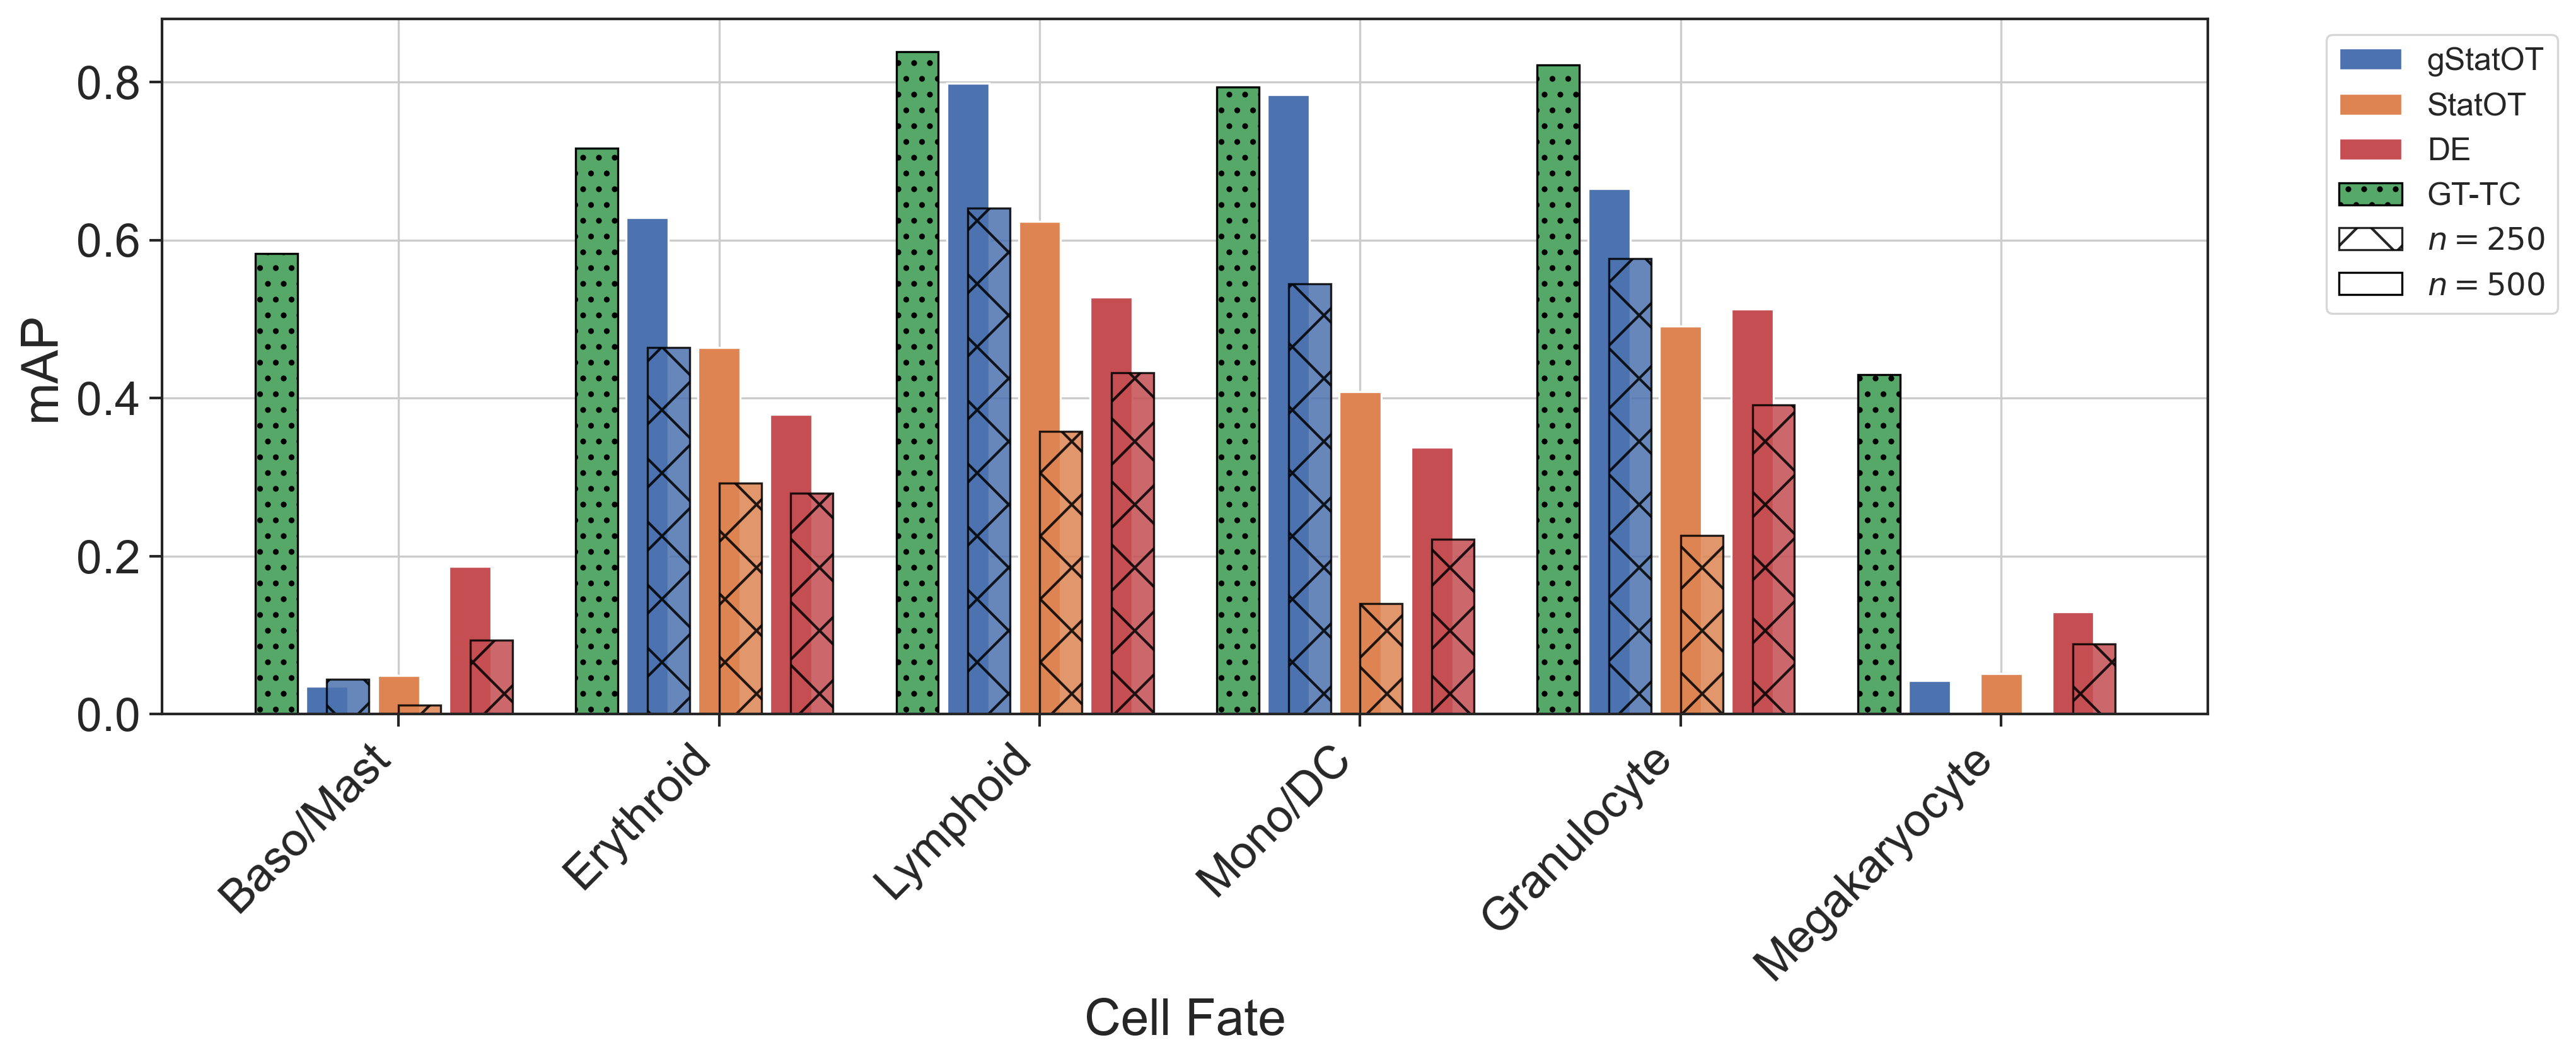

In [5]:
AP_df_n500 = pd.read_csv(f'{data_dir}/../gene_lists/driver_gene_AP_results_n=500.csv')
AP_df_n250 = pd.read_csv(f'{data_dir}/../gene_lists/driver_gene_AP_results_n=250.csv')

sns.set_style("ticks")
sns.set_context('paper', font_scale=2)
width = 1.25
gap = 0.25
n_genes = 50
x = np.arange(6) * 9.5
fate_names = np.array(['', 'Baso/Mast', 'Erythroid', 'Lymphoid', 'Mono/DC', 'Granulocyte','Megakaryocyte'])

colors = sns.color_palette("deep", 4)
colors_dict = {'gStatOT':colors[0], 'StatOT':colors[1], 'DE baseline':colors[3], 'GT-TC':colors[2]}

fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
metric = 'AP'

scores_df_ = AP_df_n250[AP_df_n250['Top genes'] == n_genes]
scores_df_500 = AP_df_n500[AP_df_n500['Top genes'] == n_genes]

ax.bar(x = x - (width + width/2) - gap, height=scores_df_500[scores_df_500['Method'].str.contains('gStatOT')].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, 
       label='', alpha=1, color=colors_dict['gStatOT'])
ax.bar(x = x - width - gap, height=scores_df_[scores_df_['Method'].str.contains('gStatOT')].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, label='', alpha=0.85, color=colors_dict['gStatOT'], hatch='x', edgecolor='black')

ax.bar(x = x, height=scores_df_500[~(scores_df_500['Method'].str.contains('gStatOT') | scores_df_500['Method'].str.contains('DE baseline') | scores_df_500['Method'].str.contains('GT-TC'))].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, label='', alpha=1, color=colors_dict['StatOT'])
ax.bar(x = x+width/2 , height=scores_df_[~(scores_df_['Method'].str.contains('gStatOT') | scores_df_['Method'].str.contains('DE baseline') | scores_df_['Method'].str.contains('GT-TC'))].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, label='', alpha=0.85, color=colors_dict['StatOT'], hatch='x', edgecolor='black')

ax.bar(x = x + width + width/2 + gap, height=scores_df_500[scores_df_500['Method'].str.contains('DE baseline')].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, label='', alpha=1, color=colors_dict['DE baseline'])
ax.bar(x = x + width + width + gap, height=scores_df_[scores_df_['Method'].str.contains('DE baseline')].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, label='', alpha=0.85, color=colors_dict['DE baseline'], hatch='x', edgecolor='black')

ax.bar(x=x - 2*gap - 2.5*width, height=scores_df_500[scores_df_500['Method'].str.contains('GT-TC')].groupby('Fate')[metric].mean()[fate_names[1:]], 
       width=width, color=colors_dict['GT-TC'], label='', hatch='..', edgecolor='black', alpha=1)

ax.bar(x=0, height=0, width=0, label=f'gStatOT', color=colors_dict['gStatOT'], alpha=1)
ax.bar(x=0, height=0, width=0, label=f'StatOT', color=colors_dict['StatOT'], alpha=1)
ax.bar(x=0, height=0, width=0, label=f'DE', color=colors_dict['DE baseline'], alpha=1)
ax.bar(x=0, height=0, width=0, label=f'GT-TC', color=colors_dict['GT-TC'], alpha=1, hatch='..', edgecolor='black')

ax.bar(x=0, height=0, width=0, label=r'$n = 250$', color='white', alpha=0.85, hatch='x', edgecolor='black')
ax.bar(x=0, height=0, width=0, label=r'$n = 500$', color='white', alpha=1, edgecolor='black')


ax.set_xticks(x, labels=fate_names[1:], rotation=45, ha='right')
ax.grid()

ax.set_ylabel('mAP')
ax.set_xlabel('Cell Fate')

# put legend on top right
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()